# SHAP - jieba 中文自動分词版本 - **測試中** - 失敗版本


## 導入模型、構建 explainer


In [1]:
from lime.lime_text import LimeTextExplainer
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import numpy as np
import jieba
import string

device = "cuda"

# 加載模型和分詞器
peft_model_id = "CMLM/ZhongJing-2-1_8b"
base_model_id = "Qwen/Qwen1.5-1.8B-Chat"
model = AutoModelForCausalLM.from_pretrained(base_model_id, device_map="auto")
model.load_adapter(peft_model_id)
tokenizer = AutoTokenizer.from_pretrained(
    peft_model_id, padding_side="right", trust_remote_code=True, pad_token=""
)


def get_model_response(question):
    # Create the prompt without context
    prompt = f"Question: {question}"
    messages = [
        {"role": "system", "content": "You are a helpful medical assistant."},
        {"role": "user", "content": prompt},
    ]

    # Prepare the input
    text = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(device)

    # Generate the response
    generated_ids = model.generate(model_inputs.input_ids, max_new_tokens=512)
    generated_ids = [
        output_ids[len(input_ids) :]
        for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Decode the response
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return response


# 自定義分詞函數
def chinese_tokenizer(text):
    # 使用 jieba 進行分詞
    words = jieba.cut(text, cut_all=False)

    # 定義要忽略的標點符號，可以擴展為包含中文標點
    punctuation = string.punctuation + "，。！？；：“”‘’（）《》、"

    # 過濾掉標點符號
    filtered_words = [word for word in words if word not in punctuation]

    return filtered_words

## 定義自動換行函數


In [2]:
import textwrap


# 基本用法
def wrap_text(text, width=70):
    # 使用textwrap.fill()直接返回換行後的文本字符串
    wrapped_text = textwrap.fill(text, width=width)
    return wrapped_text


# 更多自定義選項的用法
def wrap_text_advanced(text, width=70, initial_indent="", subsequent_indent="  "):
    wrapper = textwrap.TextWrapper(
        width=width,  # 每行最大寬度
        initial_indent=initial_indent,  # 第一行縮進
        subsequent_indent=subsequent_indent,  # 後續行縮進
        break_long_words=True,  # 允許斷開長單詞
        break_on_hyphens=True,  # 允許在連字符處斷行
    )
    wrapped_text = wrapper.fill(text)
    return wrapped_text

## 评估模型


In [3]:
print("\n=== 病人提問 ===")
# 測試文本
test_text = "张某，男，27岁。患者因昨晚饮酒发热，喝凉水数杯，早晨腹痛腹泻，大便如水色黄，腹中辘辘有声，恶心欲吐，胸中满闷不舒，口干欲冷饮，舌质红、苔白腻，脉沉细数。给出中医诊断和处方建议。"
print(wrap_text((test_text), width=30))


# 模型結果
print("\n=== 模型結果 ===")
response = get_model_response(test_text)
print(wrap_text(response, width=30))

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



=== 病人提問 ===
张某，男，27岁。患者因昨晚饮酒发热，喝凉水数杯，早晨腹痛腹
泻，大便如水色黄，腹中辘辘有声，恶心欲吐，胸中满闷不舒，口干
欲冷饮，舌质红、苔白腻，脉沉细数。给出中医诊断和处方建议。

=== 模型結果 ===
西医诊断为急性胃肠炎，诊断依据如下：
1、临床表现：患者昨晚饮酒后发热、腹痛腹泻。
2、实验室检查：血象正常，大便镜检可见红细胞增多。
3、病史及用药情况：患者未进食油腻食物。
4、辅助检查：肝功能提示谷丙转氨酶升高，凝血酶原时间延长。
中医诊断为湿热伤食证，中医治疗建议： （1）方剂：黄连汤加减
。黄连四两，去上沫、去心、甘草，加苍术、厚朴、竹茹，煎煮取汁
后入药。此为清利湿热之法。
（2）饮食调护：禁食生冷辛辣等刺激性食物；忌烟酒。
（3）注意休息，加强身体锻炼，增强机体免疫力。
（4）若病情无缓解，应及时就医诊治。


# SHAP


In [ ]:
# font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
# font_prop = fm.FontProperties(fname=font_path)

# plt.figure(figsize=(6, 4))
# plt.title("测试图表", fontsize=16)
# plt.xlabel("测试横轴", fontsize=14)
# plt.ylabel("测试纵轴", fontsize=14)
# plt.bar(["A", "B", "C"], [1, 2, 3])
# plt.show()

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [45:19, 2719.02s/it]             


特征及其影响度：
['张某', '，', '男', '，', '2', '7', '岁', '。', '患者', '因', '昨晚', '饮酒', '发热', '，', '喝', '凉', '水', '数', '杯', '，', '早晨', '腹', '痛', '腹泻', '，', '大', '便', '如', '水', '色', '黄', '，', '腹', '中', '辘', '辘', '有', '声', '，', '恶心', '欲', '吐', '，', '胸', '中', '满', '闷', '不', '舒', '，', '口', '干', '欲', '冷', '饮', '，', '舌', '质', '红', '、', '苔', '白', '腻', '，', '脉', '沉', '细', '数', '。', '给出', '中医', '诊断', '和', '处方', '建议', '。']: -0.0031


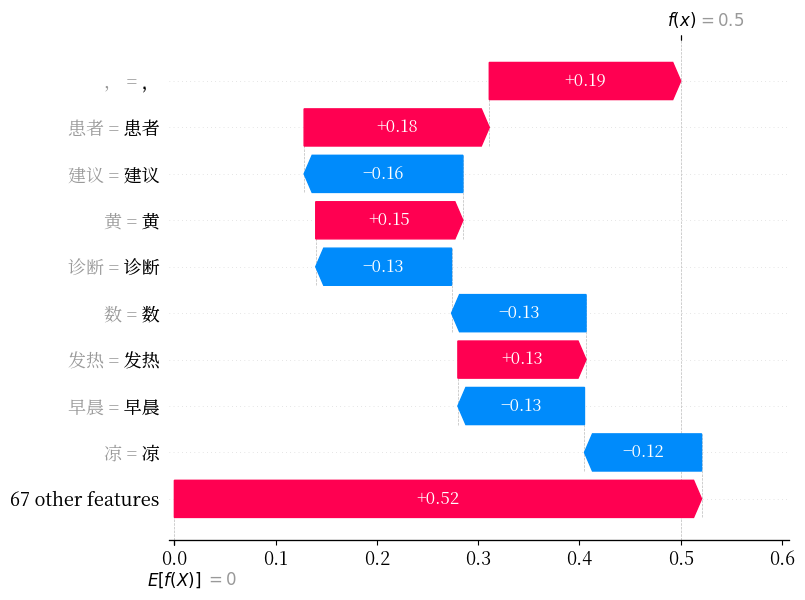

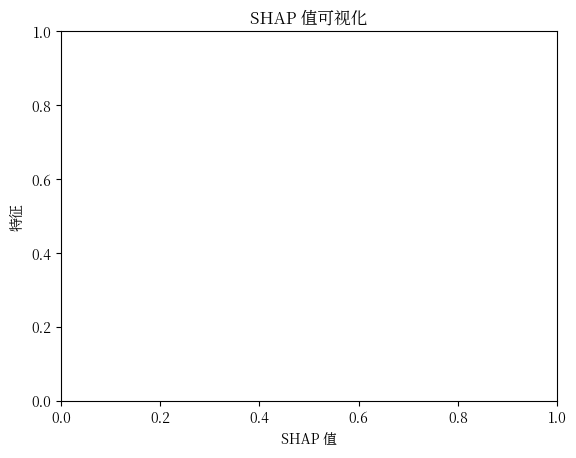

In [4]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# 設置全局字體為黑體
plt.rcParams["font.family"] = ["Noto Serif CJK JP"]
plt.rcParams["axes.unicode_minus"] = False


def convert_response_to_score(response):
    score = 0

    # 严重症状
    if "发热" in response:
        score += 1.0  # 严重症状
    if "意识模糊" in response:
        score += 1.2  # 更严重症状

    # 重要症状
    if "腹痛" in response:
        score += 0.8  # 重要症状
    if "腹泻" in response:
        score += 0.7  # 重要症状
    if "胸痛" in response:
        score += 0.9  # 重要症状

    # 中等症状
    if "恶心" in response:
        score += 0.5  # 中等症状
    if "口干" in response:
        score += 0.4  # 中等症状
    if "舌质红" in response or "苔白腻" in response:
        score += 0.6  # 中等症状
    if "脉沉细数" in response:
        score += 0.5  # 中等症状

    # 较轻症状
    if "乏力" in response:
        score += 0.3  # 较轻症状
    if "食欲减退" in response:
        score += 0.4  # 较轻症状

    # 组合症状加分
    if "腹痛" in response and "腹泻" in response:
        score += 0.5  # 腹痛和腹泻组合加分

    return score


# 定义预测函数
def predictor(texts):
    responses = []
    for text in texts:
        response = get_model_response(text)  # 获取模型响应
        score = convert_response_to_score(response)  # 使用转换函数
        responses.append(score)
    return np.array(responses)


# 创建 SHAP 解释器
explainer = shap.Explainer(predictor, tokenizer)

# 测试文本
test_text = "张某，男，27岁。患者因昨晚饮酒发热，喝凉水数杯，早晨腹痛腹泻，大便如水色黄，腹中辘辘有声，恶心欲吐，胸中满闷不舒，口干欲冷饮，舌质红、苔白腻，脉沉细数。给出中医诊断和处方建议。"

# 计算单个实例的 SHAP 值
shap_values = explainer([test_text])

# 提取特征和影响度
feature_names = shap_values.feature_names
shap_values_array = shap_values.values[0]  # 获取第一个实例的 SHAP 值

# 打印特征及其影响度
print("特征及其影响度：")
for feature, value in zip(feature_names, shap_values_array):
    print(f"{feature}: {value:.4f}")

# 可视化单个实例的 SHAP 值
plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap_values[0])

# 设置中文字体
plt.title("SHAP 值可视化")
plt.xlabel("SHAP 值")
plt.ylabel("特征")

# 显示图表
plt.show()